### Trying to cluster

In [59]:
import functions

import os
import scipy.io
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# for clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# for statistical tests
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import multipletests
import numpy as np

In [60]:
rsfMRI_info = pd.read_excel("TiMeS_rsfMRI_info.xlsx", engine="openpyxl")  
regression_info = pd.read_excel("TiMeS_regression_info_processed.xlsx", engine="openpyxl")
rsfMRI_full_info = pd.read_excel("TiMeS_rsfMRI_full_info.xlsx", engine="openpyxl")
print(regression_info.columns)
regression_info=regression_info[['Stroke_location', 'Lesion_side', 'lesion_volume_mm3']]

Index(['subject_id', 'TimePoint', 'Behavioral_assessment', 'MRI', 'Gender',
       'Age', 'Education_level', 'Lesion_side_old', 'Lesion_side', 'Combined',
       'Bilateral', 'Comments', 'Stroke_location', 'lesion_volume_mm3',
       'NIHSS', 'FAB_abstraction', 'FAB_flexibility', 'FAB_programmation',
       'FAB_sensitivity_to_interference', 'FAB_inhibitory_control',
       'FAB_environmental_autonomy', 'FAB_TOT', 'Stroop_color_time',
       'Stroop_color_error', 'Stroop_words_time', 'Stroop_words_error',
       'Stroop_interference_time', 'Stroop_interference_error',
       'Stroop_index_WC', 'Stroop_index_InC', 'Digit_forward_SPAN',
       'Digit_forward_TOTAL', 'Digit_backward_SPAN', 'Digit_backward_TOTAL',
       'Digit_sequencing_SPAN', 'Digit_sequencing_TOTAL', 'Digit_TOTAL',
       'Fugl_Meyer_right_UPPER_EXTREMITY', 'Fugl_Meyer_right_WRIST',
       'Fugl_Meyer_right_HAND', 'Fugl_Meyer_right_COORDINATION_SPEED',
       'Fugl_Meyer_right_TOTAL', 'Fugl_Meyer_left_UPPER_EXTREMITY',

In [61]:
# Folder containing the data
folder_path = "FC_matrices_times_wp11/"

# keep only ROIS
rois = [363, 364, 365, 368, 372, 373, 374, 377, 379, 361, 370, 362, 371, 10, 11, 12, 54, 56, 78, 96, 190, 191, 192, 234, 236, 258, 276, 8, 9, 51, 52, 53, 188, 189, 231, 232, 233]
rois = [roi - 1 for roi in rois]

t1_matrices, rsfMRI_full_info, rsfMRI_info, t1_subjects = functions.load_data_T1_only(folder_path, rois)
all_matrices, rsfMRI_full_info, rsfMRI_info, all_subjects = functions.load_data(folder_path, rois)
t1_t3_matrices, rsfMRI_full_info, rsfMRI_info, t1_t3_subjects = functions.load_data_2(folder_path, rois)
t1_t4_matrices, rsfMRI_full_info, rsfMRI_info, t1_t4_subjects = functions.load_data_3(folder_path, rois)
#matrices = functions.matrices_to_wide_df(matrices)

In [62]:
print("number of subjects with all matrices: ", len(all_subjects))
print("number of subjects with T1 and T3 matrices: ", len(t1_t3_subjects))
print("number of subjects with T1 and T4 matrices: ", len(t1_t4_subjects))

number of subjects with all matrices:  22
number of subjects with T1 and T3 matrices:  39
number of subjects with T1 and T4 matrices:  36


Better to keep T1 and T3 as more subjects have these two !
From now on I'll work with matrices

In [63]:
print("matrices column names: ", t1_t3_matrices.columns)

matrices column names:  Index(['subject_id', 'T1_matrix', 'T3_matrix', 'Lesion_side',
       'Stroke_location', 'lesion_volume_mm3'],
      dtype='object')


##### Cluster for all matrices

In [64]:
categorical_cols = ['Lesion_side', 'Stroke_location']
numerical_cols = ['lesion_volume_mm3']

all_matrices_labeled = functions.cluster_and_plot(all_matrices, numerical_cols_names= numerical_cols, categorical_cols_name=categorical_cols, clusters=4)

TypeError: cluster_and_plot() got an unexpected keyword argument 'clusters'

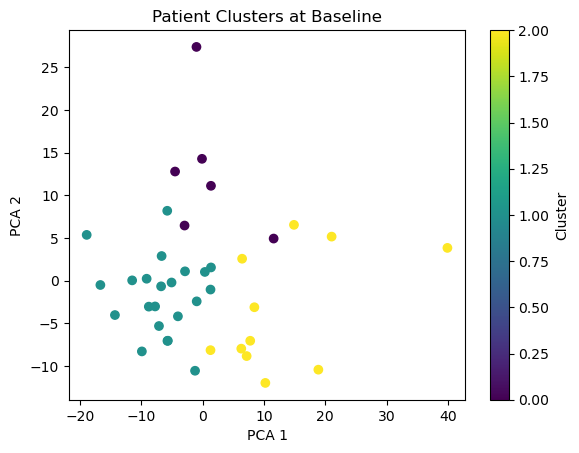

Silhouette score: 0.0756123487387197
Cluster 0: ['s008', 's039', 's025', 's068', 's033', 's016']
Cluster 1: ['s031', 's065', 's006', 's055', 's041', 's070', 's078', 's040', 's013', 's066', 's057', 's050', 's032', 's051', 's067', 's027', 's020', 's011', 's074', 's017', 's019', 's075']
Cluster 2: ['s036', 's001', 's014', 's003', 's060', 's029', 's042', 's080', 's073', 's021', 's081']


In [ ]:
t1_t3_matrices_labeled = functions.cluster_and_plot(t1_t3_matrices, numerical_cols_names= numerical_cols, categorical_cols_name=categorical_cols)

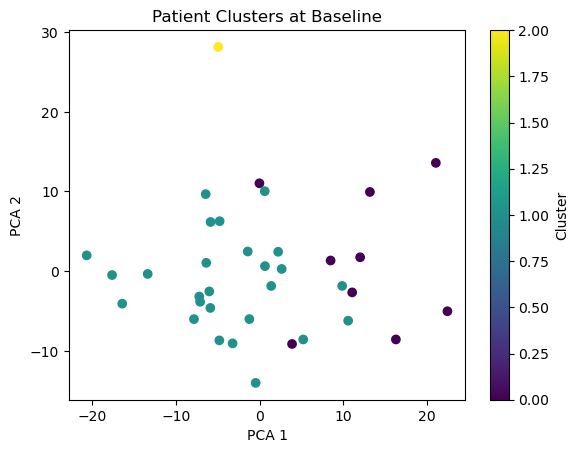

Silhouette score: 0.08170067157585763
Cluster 0: ['s065', 's052', 's082', 's047', 's003', 's002', 's042', 's021', 's081']
Cluster 1: ['s031', 's036', 's008', 's037', 's030', 's006', 's001', 's055', 's041', 's046', 's076', 's040', 's014', 's013', 's057', 's068', 's050', 's004', 's067', 's027', 's016', 's011', 's074', 's017', 's019', 's075']
Cluster 2: ['s039']


In [ ]:
t1_t4_matrices_labeled = functions.cluster_and_plot(t1_t4_matrices, numerical_cols_names= numerical_cols, categorical_cols_name=categorical_cols)

### Beginning of statistical testing

X_T1 shape:  (22, 666)
X_T4 shape:  (22, 666)


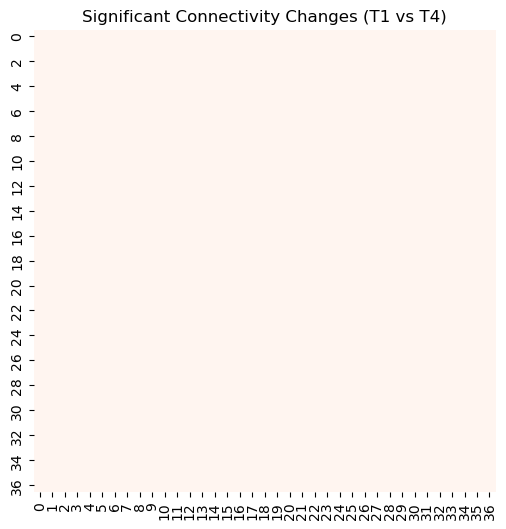

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
def compare_T1_T4(df, rois, alpha=0.05):
    T1_matrices = df['T1_matrix']
    T4_matrices = df['T4_matrix']

    # Ensure matching subjects
    common_subjects = set(T1_matrices.index) & set(T4_matrices.index)
    T1 = [functions.flatten_upper(df.loc[s, 'T1_matrix']) for s in common_subjects]
    T4 = [functions.flatten_upper(df.loc[s, 'T4_matrix']) for s in common_subjects]

    X_T1 = np.array(T1)
    print("X_T1 shape: ", np.shape(X_T1))
    X_T4 = np.array(T4)
    print("X_T4 shape: ", np.shape(X_T4))

    # Paired t-test
    t_stats, p_vals = ttest_rel(X_T1, X_T4, axis=0)

    # Multiple comparisons correction (FDR)
    reject, p_vals_corrected, _, _ = multipletests(p_vals, alpha=alpha, method='fdr_bh')

    # Create a matrix to visualize
    n_edges = X_T1.shape[1]
    n_rois = len(rois)
    signif_matrix = np.zeros((n_rois, n_rois))

    # Fill upper triangle
    triu_idx = np.triu_indices(n_rois, k=1)
    signif_matrix[triu_idx] = reject.astype(int)
    signif_matrix += signif_matrix.T  # Make symmetric

    return signif_matrix, p_vals_corrected.reshape(-1), reject.reshape(-1)

# Visualize
signif_matrix, p_corrected, reject = compare_T1_T4(all_matrices, rois)

plt.figure(figsize=(8, 6))
sns.heatmap(signif_matrix, cmap='Reds', square=True, cbar=False)
plt.title('Significant Connectivity Changes (T1 vs T4)')
plt.show()
print(signif_matrix)


X_T1 shape:  (39, 666)
X_T4 shape:  (39, 666)


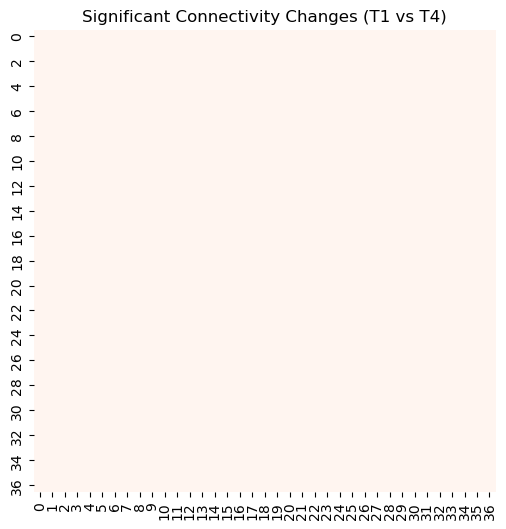

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
def compare_T1_T3(df, rois, alpha=0.05):
    T1_matrices = df['T1_matrix']
    T3_matrices = df['T3_matrix']

    # Ensure matching subjects
    common_subjects = set(T1_matrices.index) & set(T3_matrices.index)
    T1 = [functions.flatten_upper(df.loc[s, 'T1_matrix']) for s in common_subjects]
    T3 = [functions.flatten_upper(df.loc[s, 'T3_matrix']) for s in common_subjects]

    X_T1 = np.array(T1)
    print("X_T1 shape: ", np.shape(X_T1))
    X_T3 = np.array(T3)
    print("X_T4 shape: ", np.shape(X_T3))

    # Paired t-test
    t_stats, p_vals = ttest_rel(X_T1, X_T3, axis=0)

    # Multiple comparisons correction (FDR)
    reject, p_vals_corrected, _, _ = multipletests(p_vals, alpha=alpha, method='fdr_bh')

    # Create a matrix to visualize
    n_edges = X_T1.shape[1]
    n_rois = len(rois)
    signif_matrix = np.zeros((n_rois, n_rois))

    # Fill upper triangle
    triu_idx = np.triu_indices(n_rois, k=1)
    signif_matrix[triu_idx] = reject.astype(int)
    signif_matrix += signif_matrix.T  # Make symmetric

    return signif_matrix, p_vals_corrected.reshape(-1), reject.reshape(-1)

# Visualize
signif_matrix, p_corrected, reject = compare_T1_T3(t1_t3_matrices, rois)

plt.figure(figsize=(8, 6))
sns.heatmap(signif_matrix, cmap='Reds', square=True, cbar=False)
plt.title('Significant Connectivity Changes (T1 vs T4)')
plt.show()
print(signif_matrix)


In [ ]:
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import multipletests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def compare_T1_T4_by_cluster(df, rois, alpha=0.05):
    n_rois = len(rois)
    results = {}

    for cluster in sorted(df['cluster'].unique()):
        print(f"\nAnalyzing Cluster {cluster}...")

        # Subset to current cluster
        cluster_df = df[df['cluster'] == cluster]

        # Ensure subjects have both T1 and T4
        cluster_df = cluster_df.dropna(subset=['T1_matrix', 'T4_matrix'])

        if cluster_df.empty:
            print(f" - No data for Cluster {cluster}")
            continue

        # Flatten matrices
        X_T1 = np.array([functions.flatten_upper(m) for m in cluster_df['T1_matrix']])
        X_T4 = np.array([functions.flatten_upper(m) for m in cluster_df['T4_matrix']])

        # Paired t-test
        t_stats, p_vals = ttest_rel(X_T1, X_T4, axis=0)

        # FDR correction
        reject, p_vals_corrected, _, _ = multipletests(p_vals, alpha=alpha, method='fdr_bh')

        # Create symmetric significance matrix
        signif_matrix = np.zeros((n_rois, n_rois))
        triu_idx = np.triu_indices(n_rois, k=1)
        signif_matrix[triu_idx] = reject.astype(int)
        signif_matrix += signif_matrix.T

        # Store results
        results[cluster] = {
            'signif_matrix': signif_matrix,
            'p_corrected': p_vals_corrected,
            'rejected': reject,
        }

        # Plot
        plt.figure(figsize=(7, 6))
        sns.heatmap(signif_matrix, cmap='Reds', square=True, cbar=False)
        plt.title(f'Significant Changes (T1 vs T4) - Cluster {cluster}')
        plt.tight_layout()
        plt.show()

    return results


#### T1 vs T3

In [ ]:
# Create lists of matrices
t1_matrices = [matrix.values if isinstance(matrix, pd.DataFrame) else matrix for matrix in t1_t3_matrices['T1_matrix']]
t3_matrices = [matrix.values if isinstance(matrix, pd.DataFrame) else matrix for matrix in t1_t3_matrices['T3_matrix']]

# Optionally convert to numpy arrays (shape: [n_subjects, n_rois, n_rois])
t1_array = np.stack(t1_matrices)
t3_array = np.stack(t3_matrices)

print("shape of T1 matrix: ", np.shape(t1_matrices))
print(t1_matrices[0])

shape of T1 matrix:  (39, 37, 37)
[[ 1.          0.52103094 -0.02089483 ... -0.05700582 -0.05791558
   0.00342491]
 [ 0.52103094  1.         -0.0108931  ...  0.02026188 -0.05439006
   0.0787652 ]
 [-0.02089483 -0.0108931   1.         ... -0.29986604 -0.2355015
  -0.22227553]
 ...
 [-0.05700582  0.02026188 -0.29986604 ...  1.          0.75523533
   0.37349374]
 [-0.05791558 -0.05439006 -0.2355015  ...  0.75523533  1.
   0.14631578]
 [ 0.00342491  0.0787652  -0.22227553 ...  0.37349374  0.14631578
   1.        ]]


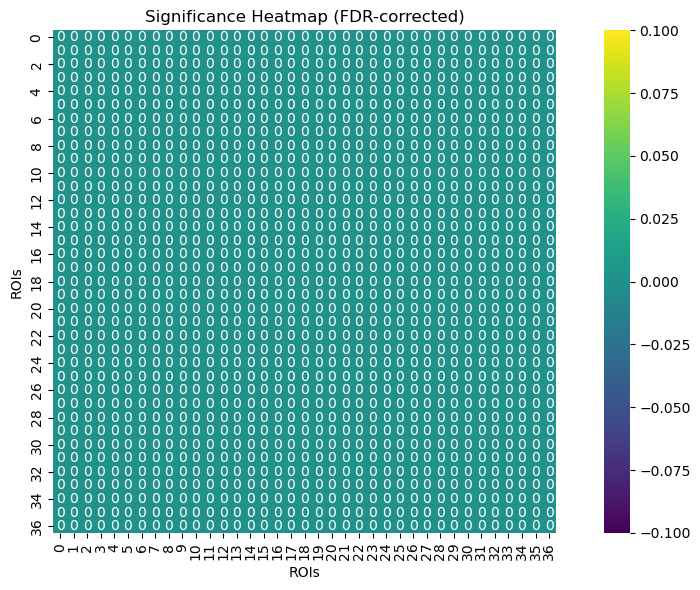

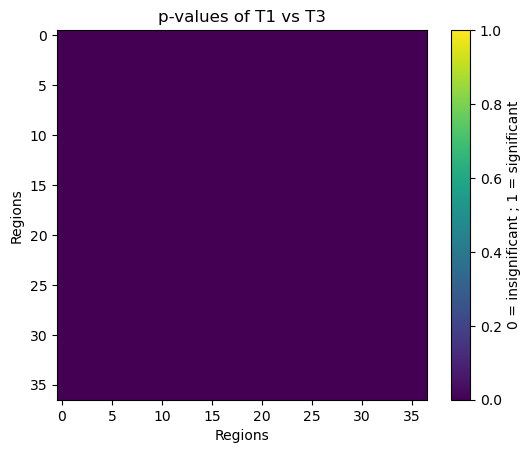

In [ ]:
# Paired t-test
t_stat, p_val = ttest_rel(t1_array, t3_array, axis=0)

# Flatten p-values to 1D if needed
p_val_flat = p_val.ravel()

# FDR correction
alpha = 0.05
reject, p_vals_corrected, _, _ = multipletests(p_val_flat, alpha=alpha, method='holm')

# Reshape corrected p-values and reject back to original shape if necessary
p_vals_corrected = p_vals_corrected.reshape(p_val.shape)
reject = reject.reshape(p_val.shape)

# Create significant matrix
significant_matrix = np.zeros_like(p_val, dtype=int)
significant_matrix[reject] = 1

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(significant_matrix, cmap='viridis', cbar=True, annot=True, square=True)
plt.title("Significance Heatmap (FDR-corrected)")
plt.xlabel("ROIs")
plt.ylabel("ROIs")
plt.tight_layout()
plt.show()

def make_plot(matrix, sub, cmap, vmin=0,vmax = 1, saveas = "sub"):
    
    plt.imshow(matrix, cmap= cmap, vmin= vmin, vmax=vmax, interpolation='Nearest') 
    plt.colorbar(label='0 = insignificant ; 1 = significant')
    plt.title(f'p-values of {sub}')
    plt.xlabel('Regions')
    plt.ylabel('Regions')
    #plt.savefig(f'{saveas}.png')
    plt.show()
    
    return None

make_plot(significant_matrix, "T1 vs T3", cmap = "viridis", vmin=0, vmax=1, saveas = "T1_vs_T3_significant_matrix")

#### T1 vs T4

In [ ]:
# Create lists of matrices
t1_matrices = [matrix.values if isinstance(matrix, pd.DataFrame) else matrix for matrix in t1_t4_matrices['T1_matrix']]
t4_matrices = [matrix.values if isinstance(matrix, pd.DataFrame) else matrix for matrix in t1_t4_matrices['T4_matrix']]

# Optionally convert to numpy arrays (shape: [n_subjects, n_rois, n_rois])
t1_array = np.stack(t1_matrices)
t4_array = np.stack(t4_matrices)

print("shape of T1 matrix: ", np.shape(t1_matrices))
print(t1_matrices[0])

shape of T1 matrix:  (36, 37, 37)
[[ 1.          0.52103094 -0.02089483 ... -0.05700582 -0.05791558
   0.00342491]
 [ 0.52103094  1.         -0.0108931  ...  0.02026188 -0.05439006
   0.0787652 ]
 [-0.02089483 -0.0108931   1.         ... -0.29986604 -0.2355015
  -0.22227553]
 ...
 [-0.05700582  0.02026188 -0.29986604 ...  1.          0.75523533
   0.37349374]
 [-0.05791558 -0.05439006 -0.2355015  ...  0.75523533  1.
   0.14631578]
 [ 0.00342491  0.0787652  -0.22227553 ...  0.37349374  0.14631578
   1.        ]]


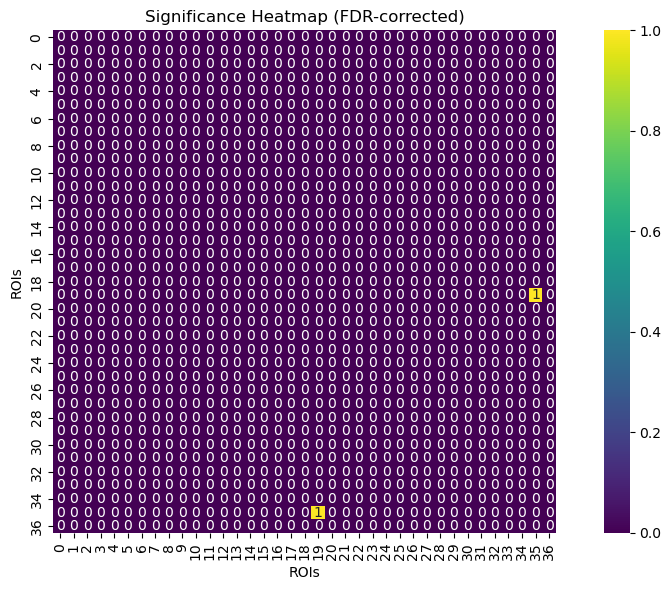

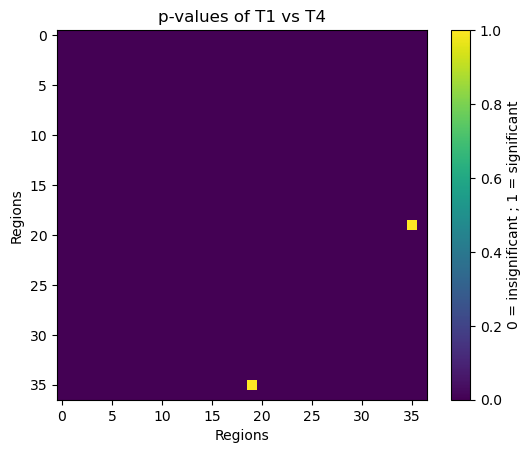

In [ ]:
# Paired t-test
t_stat, p_val = ttest_rel(t1_array, t4_array, axis=0)

# Flatten p-values to 1D if needed
p_val_flat = p_val.ravel()

# FDR correction
alpha = 0.05
reject, p_vals_corrected, _, _ = multipletests(p_val_flat, alpha=alpha, method='holm')

# Reshape corrected p-values and reject back to original shape if necessary
p_vals_corrected = p_vals_corrected.reshape(p_val.shape)
reject = reject.reshape(p_val.shape)

# Create significant matrix
significant_matrix = np.zeros_like(p_val, dtype=int)
significant_matrix[reject] = 1

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(significant_matrix, cmap='viridis', cbar=True, annot=True, square=True)
plt.title("Significance Heatmap (FDR-corrected)")
plt.xlabel("ROIs")
plt.ylabel("ROIs")
plt.tight_layout()
plt.show()

def make_plot(matrix, sub, cmap, vmin=0,vmax = 1, saveas = "sub"):
    
    plt.imshow(matrix, cmap= cmap, vmin= vmin, vmax=vmax, interpolation='Nearest') 
    plt.colorbar(label='0 = insignificant ; 1 = significant')
    plt.title(f'p-values of {sub}')
    plt.xlabel('Regions')
    plt.ylabel('Regions')
    plt.savefig(f'{saveas}.png')
    plt.show()
    
    return None

make_plot(significant_matrix, "T1 vs T4", cmap = "viridis", vmin=0, vmax=1)

#### Code to do it by cluster for both T3 and T4


Analyzing Cluster 0...
shape of T1 matrix:  (36, 37, 37)


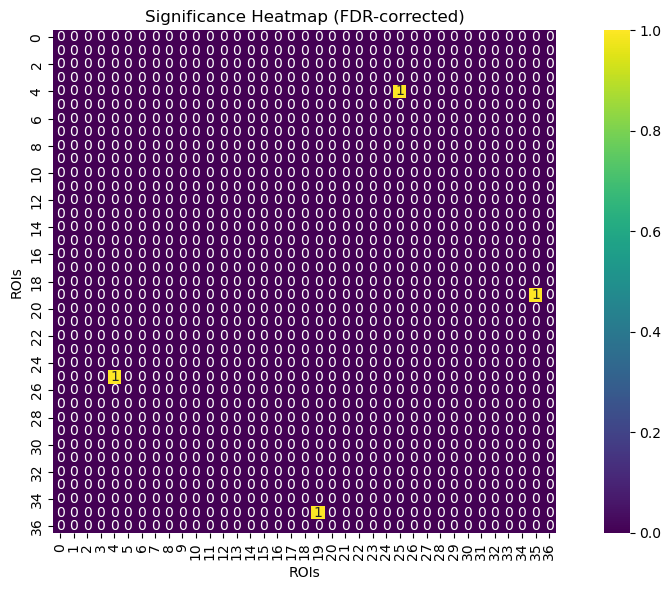


Analyzing Cluster 1...
shape of T1 matrix:  (36, 37, 37)


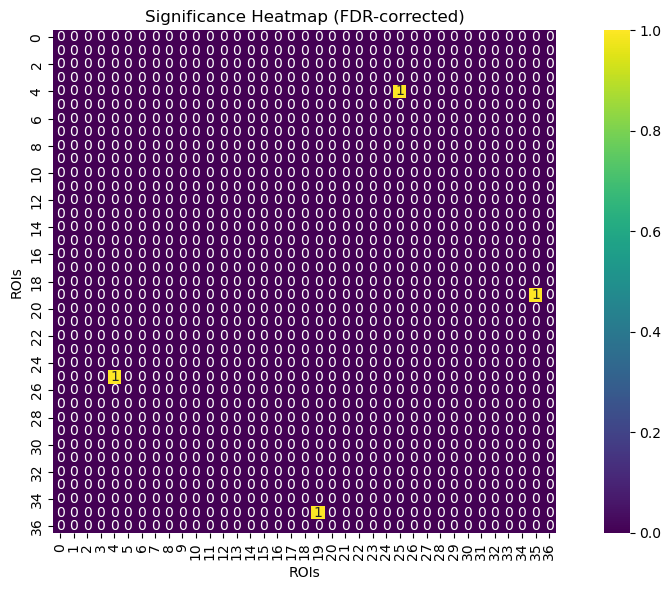


Analyzing Cluster 2...
shape of T1 matrix:  (36, 37, 37)


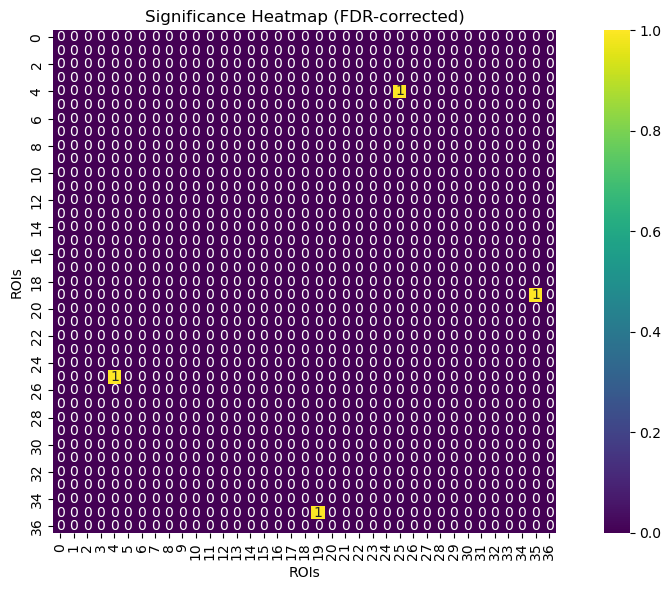

{0: {'signif_matrix': array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]),
  'p_corrected': array([[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]),
  'rejected': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]])},
 1: {'signif_matrix': array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ...

In [ ]:
functions.compare_T1_T_by_cluster(t1_t4_matrices_labeled, rois, tp = 4, alpha=0.05)

### Regression Analysis